# Portfolio Risk & Return

In [72]:
from typing import List
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [5]:
# probability weighted mean
def prob_mean(values: List[float], prob: List[float]) -> float:
    return np.dot(values, prob)

# probability weighted standard deviation
def prob_std(values: List[float], prob: List[float]) -> float:
    er = prob_mean(values, prob)
    return np.dot((values - er)**2, prob) ** 0.5

# portfolio probability weighted mean
def prob_port_mean(df, prob, weights):
    # calculate expected returns of each assets
    asset_returns = np.dot(df.T, prob)
    # calculate weighted return
    return np.dot(asset_returns, weights)

# portfolio probability weighted risk
def prob_port_risk(df, prob, weights):
    # calculate weighted returns in each state of economy
    returns = np.dot(df, weights)
    # calculate protfolio expected return
    er = prob_port_mean(df, prob, weights)
    # calculate probability weighted square of deviation from expected return
    return np.dot((returns - er)**2, prob) ** 0.5

# probability weighted covariance
def prob_cov(x, y, prob):
    ex = prob_mean(x, prob)
    ey = prob_mean(y, prob)
    return np.dot( (x - ex) * (y - ey) , prob)

# probability weighted correlation
def prob_cor(x, y, prob):
    covariance = prob_cov(x, y, prob)
    stdx = prob_std(x, prob)
    stdy = prob_std(y, prob)
    return covariance / (stdx * stdy)

## Expected Return

In [6]:
P = np.array([0.1, 0.4, 0.3, 0.2])
weights = np.array([1/3, 1/3, 1/3])

df = pd.DataFrame({
  "Toyota": [6, 7.5, 2, -3],
  "Pfizer": [2.5, -0.5, 1, 13],
  "Walmart": [4.5, 5.5, 4.0, -1]
})
df

,Toyota,Pfizer,Walmart
0,6.0,2.5,4.5
1,7.5,-0.5,5.5
2,2.0,1.0,4.0
3,-3.0,13.0,-1.0


In [23]:
pe = prob_port_mean(df, P, weights)
pe

3.4

## Risk

In [24]:
risk = prob_port_risk(df, P, weights)
risk

0.8339997335464538

## Correlation

In [25]:
prob_cor(df['Toyota'], df['Walmart'], P)

0.9362004766821973

## Minimum Variance Portfolio

In [73]:
assets_df = pd.DataFrame({
  'E': [0.1355, 0.1497],
  'Std': [0.1535, 0.2298]
}, index=['US', 'Japan'])
corr = 0.2663

use = assets_df.at['US', 'E']
jpe = assets_df.at['Japan', 'E']
usv = assets_df.at['US', 'Std']
jpv = assets_df.at['Japan', 'Std']
assets_df

,E,Std
US,0.1355,0.1535
Japan,0.1497,0.2298


Find the optimal weight for US

In [85]:
def portfolio_variance(weight_us):
  return (weight_us**2) * (usv**2) \
    + ((1-weight_us)**2) * (jpv**2) \
    + 2 * weight_us * (1-weight_us) * usv * jpv * corr

bounds = ((0, 1),)
initial_guess = 0
optimized_result = minimize(portfolio_variance, initial_guess, 
  method='SLSQP',
  bounds=bounds)

wus = optimized_result.x[0]
wjp = 1 - wus
mvp = {
  'w_US': wus,
  'w_Japan': wjp,
  'E': wus*use + wjp*jpe,
  'Std': (wus**2*usv**2 + wjp**2*jpv**2 + 2*wus*wjp*usv*jpv*corr)**0.5
}
mvp

{'w_US': 0.7539437736585762,
 'w_Japan': 0.24605622634142377,
 'E': 0.13899399841404822,
 'Std': 0.14168963368419615}

## Mean-variance frontier

Construct combination portfolios

In [78]:
p_df = pd.DataFrame({
  'w_US': np.arange(0, 1.001, 0.001), 
})

# calculate values for other column
p_df['w_Japan'] = 1 - p_df['w_US']
p_df['E'] = p_df['w_US'] * use + p_df['w_Japan'] * jpe
p_df['Std'] = ((p_df['w_US']**2) * (usv**2) \
  + (p_df['w_Japan']**2) * (jpv**2) \
  + 2 * p_df['w_US'] * p_df['w_Japan'] * usv * jpv * corr) ** 0.5
p_df

,w_US,w_Japan,E,Std
0,0.000,1.000,0.149700,0.229800
1,0.001,0.999,0.149686,0.229611
2,0.002,0.998,0.149672,0.229422
3,0.003,0.997,0.149657,0.229234
4,0.004,0.996,0.149643,0.229045
...,...,...,...,...
996,0.996,0.004,0.135557,0.153133
997,0.997,0.003,0.135543,0.153225
998,0.998,0.002,0.135528,0.153316
999,0.999,0.001,0.135514,0.153408


Plot mean-variance frontier

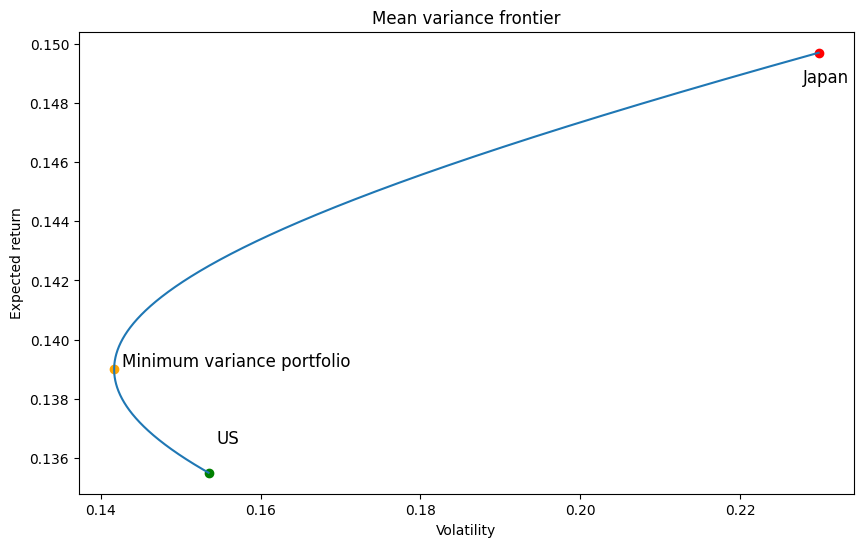

In [91]:
# Create the plot
fig, ax = plt.subplots(figsize=(10,6))

# plot the mean variance frontier
ax.plot(p_df['Std'], p_df['E'])

# plot japan
jpx = p_df.at[0, 'Std']
jpy = p_df.at[0, 'E']
ax.scatter(jpx, jpy, color='red')
ax.text(jpx-0.002, jpy-0.001, 'Japan', fontsize=12)

# plot us
usx = p_df.at[1000, 'Std']
usy = p_df.at[1000, 'E']
ax.scatter(usx, usy, color='green')
ax.text(usx+0.001, usy+0.001, 'US', fontsize=12)

# plot minimum variance portfolio
mpx = mvp['Std']
mpy = mvp['E']
ax.scatter(mpx, mpy, color='orange')
ax.text(mpx+0.001, mpy+0.0001, 'Minimum variance portfolio', fontsize=12)

# add title and x/y-axis labels
plt.title('Mean variance frontier')
plt.xlabel('Volatility')
plt.ylabel('Expected return')

plt.show()